# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

## Introducción al Aprendizaje Profundo

### Examen de _media materia_

Alumno: Herrador, Emanuel Nicolás

---


## Índice


- [1. Introducción](#1-introducción)
- [2. Desarrollo previo](#2-desarrollo-previo)
  - [2.1. Importación de librerías](#21-importación-de-librerías)
  - [2.2. Carga de datos](#22-carga-de-datos)
- [3. Descripción de los datos](#3-descripción-de-los-datos)
- [4. Análisis descriptivo de los datos (_inspección_)](#4-análisis-descriptivo-de-los-datos-inspección)
  - [4.1. Análisis de feature vs. target (Diabetes_binary)](#41-análisis-de-feature-vs-target-diabetes_binary)
  - [4.2. Análisis de correlación](#42-análisis-de-correlación)
  - [4.3. Features elegidas](#43-features-elegidas)
- [5. Preprocesamiento y división de datos](#5-preprocesamiento-y-división-de-datos)
  - [5.1. Selección de features](#51-selección-de-features)
  - [5.2. Escalado de variables](#52-escalado-de-variables)
  - [5.3. División en conjuntos de entrenamiento, testing y validación](#53-división-en-conjuntos-de-entrenamiento-testing-y-validación)
- [6. Desarrollo de modelos](#6-desarrollo-de-modelos)
  - [6.1. Modelo 1: Baseline (_modelo simple_)](#61-modelo-1-baseline-modelo-simple)
  - [6.2. Modelo 2: Mejora al baseline](#62-modelo-2-mejora-al-baseline)
  - [6.3. Modelo 3: Red más profunda](#63-modelo-3-red-más-profunda)
- [7. Comparación de modelos](#7-comparación-de-modelos)
- [8. Conclusión](#8-conclusión)


## 1. Introducción


El presente trabajo consiste en el desarrollo, creación y análisis de modelos de aprendizaje profundo para clasificación (en particular, se mostrarán 3) con el uso de _PyTorch_ con el objetivo de predecir la posibilidad de que una persona padezca diabetes en base a las respuestas realizadas en una encuesta.

Puntualmente, se trabajará con las respuestas de la encuesta BRFSS de 2015, que es una encuesta telefónica realizada por los Centros para el Control y la Prevención de Enfermedades de los Estados Unidos (CDC) a más de 400,000 personas. La encuesta incluye preguntas sobre la salud, la dieta, la actividad física, el uso de servicios de salud y más.

El dataset original se encuentra en [Kaggle](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset/data?select=diabetes_binary_5050split_health_indicators_BRFSS2015.csv).


## 2. Desarrollo previo


### 2.1. Importación de librerías


Las librerías que vamos a usar en el presente proyecto son las siguientes:


In [1]:
import utility
import torch.nn as nn
import torch
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

# For reproducibility
random_seed = 3476
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Ignore warnings
warnings.filterwarnings('ignore')

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### 2.2. Carga de datos


Realizamos la carga de los datos que vamos a utilizar en el proyecto:


In [2]:
# Load the data
file_path = './data/diabetes_binary_5050split_health_indicators_BRFSS2015.csv'
DATA = pd.read_csv(file_path)

# Check the value types (all integers)
assert all(map(lambda x: x.is_integer(), DATA.values.flatten()))

DATA = DATA.astype(int)

# Show the first few rows and the data information
DATA.info()
DATA.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Diabetes_binary       70692 non-null  int64
 1   HighBP                70692 non-null  int64
 2   HighChol              70692 non-null  int64
 3   CholCheck             70692 non-null  int64
 4   BMI                   70692 non-null  int64
 5   Smoker                70692 non-null  int64
 6   Stroke                70692 non-null  int64
 7   HeartDiseaseorAttack  70692 non-null  int64
 8   PhysActivity          70692 non-null  int64
 9   Fruits                70692 non-null  int64
 10  Veggies               70692 non-null  int64
 11  HvyAlcoholConsump     70692 non-null  int64
 12  AnyHealthcare         70692 non-null  int64
 13  NoDocbcCost           70692 non-null  int64
 14  GenHlth               70692 non-null  int64
 15  MentHlth              70692 non-null  int64
 16  Phys

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,0,1,26,0,0,0,1,0,...,1,0,3,5,30,0,1,4,6,8
1,0,1,1,1,26,1,1,0,0,1,...,1,0,3,0,0,0,1,12,6,8
2,0,0,0,1,26,0,0,0,1,1,...,1,0,1,0,10,0,1,13,6,8
3,0,1,1,1,28,1,0,0,1,1,...,1,0,3,0,3,0,1,11,6,8
4,0,0,0,1,29,1,0,0,1,1,...,1,0,2,0,0,0,0,8,5,8


## 3. Descripción de los datos


El dataset es una recopilación de las respuestas de la encuesta BRFSS (The Behavioral Risk Factor Surveillance System), la cual es una encuesta telefónica relacionada con la salud que recopila anualmente el CDC (Centers for Disease Control and Prevention).

Las respuestas recopiladas son realizadas a estadounidenses y son sobre conductas de riesgo relacionadas con la salud, afecciones crónicas y el uso de servicios preventivos. En nuestro caso, la idea será utilizarlas para predecir el padecimiento de _diabetes_ en un individuo.

En particular, el dataset que consideraremos (`diabetes_binary_5050split_health_indicators_BRFSS2015.csv`) es un conjunto de datos limpio de 70.692 respuestas a la encuesta BRFSS2015. Tiene una división equitativa del 50-50 de encuestado sin diabetes y con prediabetes o diabetes, por lo que se encuentra equilibrado. Respecto a las características, tiene las siguientes:

- `Diabetes_binary`: ¿Presencia de diabetes? - **0/1**
- `HighBP`: ¿Presión arterial alta? - **0/1**
- `HighChol`: ¿Colesterol alto? - **0/1**
- `CholCheck`: ¿Se hizo un control de colesterol en los últimos 5 años? - **0/1**
- `BMI`: Índice de masa corporal
- `Smoker`: ¿Ha fumado más de 100 cigarillos en toda la vida? - **0/1**
- `Stroke`: ¿Has tenido un derrame cerebral? - **0/1**
- `HeartDiseaseorAttack`: ¿Has tenido/tienes una enfermedad cardíaca coronaria o infarto de miocardio? - **0/1**
- `PhysActivity`: ¿Has hecho actividad física en los últimos 30 días (fuera del trabajo)? - **0/1**
- `Fruits`: ¿Consumes frutas todos los días? - **0/1**
- `Veggies`: ¿Consumes verduras todos los días? - **0/1**
- `HvyAlcoholConsump`: ¿Consumes mucho alcohol? - **0/1**
  - Las medidas son >= 14 para hombres y >= 7 para mujeres, ambos adultos, considerando cantidad de bebidas por semana
- `AnyHealthcare`: ¿Tienes cobertura médica? - **0/1**
- `NoDocbcCost`: ¿En el último año tuviste que ir al médico pero no pudiste por el costo? - **0/1**
- `GenHlth`: Escala de salud (**1-5**):
  - **1**: excelente
  - **2**: muy buena
  - **3**: buena
  - **4**: regular
  - **5**: pobre
- `MentHlth`: Cantidad de días de mala salud mental al mes (**1-30**).
- `PhysHlth`: Cantidad de días enfermo o lesionado en el último mes (**1-30**)
- `DiffWalk`: ¿Tienes dificultad para caminar? - **0/1**
- `Sex`: Sexo
  - **0**: mujer
  - **1**: hombre
- `Age`: Categoría de edad según escala _\_AGEG5YR_ (13 niveles)
  - **1**: 18-24
  - **2**: 25-29
  - **3**: 30-34
  - **4**: 35-39
  - **5**: 40-44
  - **6**: 45-49
  - **7**: 50-54
  - **8**: 55-59
  - **9**: 60-64
  - **10**: 65-69
  - **11**: 70-74
  - **12**: 75-79
  - **13**: 80-..
- `Education`: Nivel de educación según escala _EDUCA_
  - **1**: Nunca fue a la escuela o solo hizo jardín
  - **2**: Grados 1-8 (Primario)
  - **3**: Grados 9-11 (Secundario incompleto)
  - **4**: Grado 12 o GED (Secundario completo)
  - **5**: Universidad 1-3 (Universitario incompleto o técnico)
  - **6**: Universidad 4-+ (Universitario completo)
- `Income`: Escala de ingresos según _INCOME2_
  - **1**: < $10k
  - **2**: < $15k
  - **3**: < $20k
  - **4**: < $25k
  - **5**: < $35k
  - **6**: < $50k
  - **7**: < $75k
  - **8**: >= $75k

Las preguntas y escalas se pueden ver en el reporte de respuestas a la encuesta de 2015 que se encuentra [aquí](https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf).


## 4. Análisis descriptivo de los datos (_inspección_)


### 4.1. Análisis de feature vs. target (Diabetes_binary)


En este punto, vamos a analizar nuestras variables y su relación con la variable objetivo (`Diabetes_binary`), para poder entender mejor los datos con los que estamos trabajando y elegir las variables/características más representativas para usar en el desarrollo de los modelos de Aprendizaje Profundo.

Por ello mismo, primero grafiquemos las distribuciones de cada _feature_ y su relación con la diabetes:


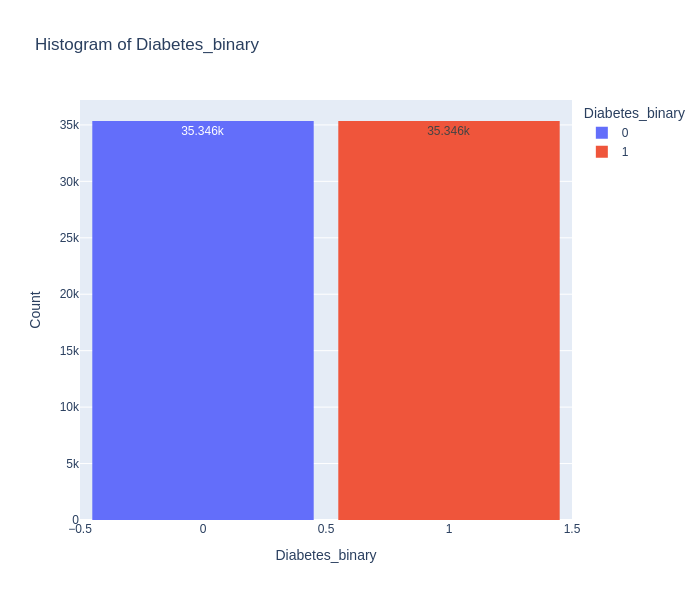

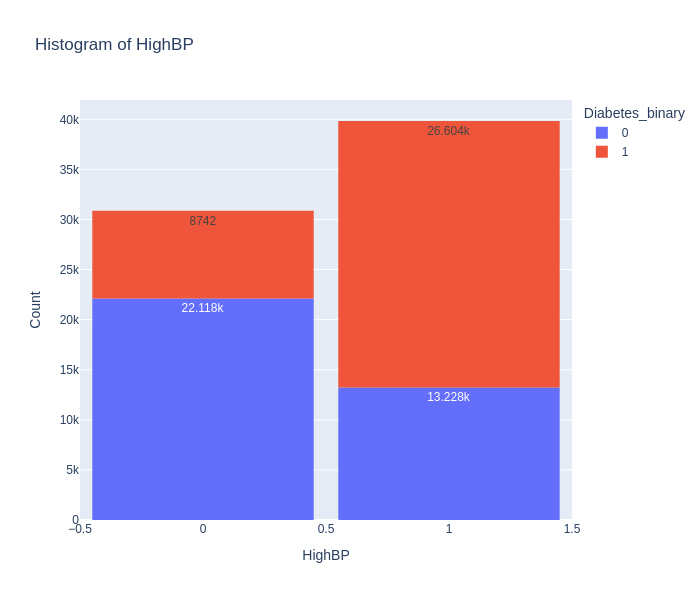

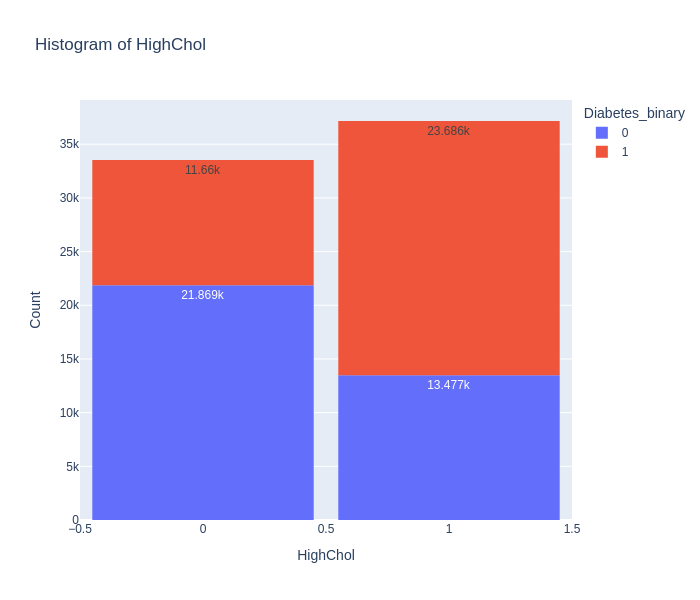

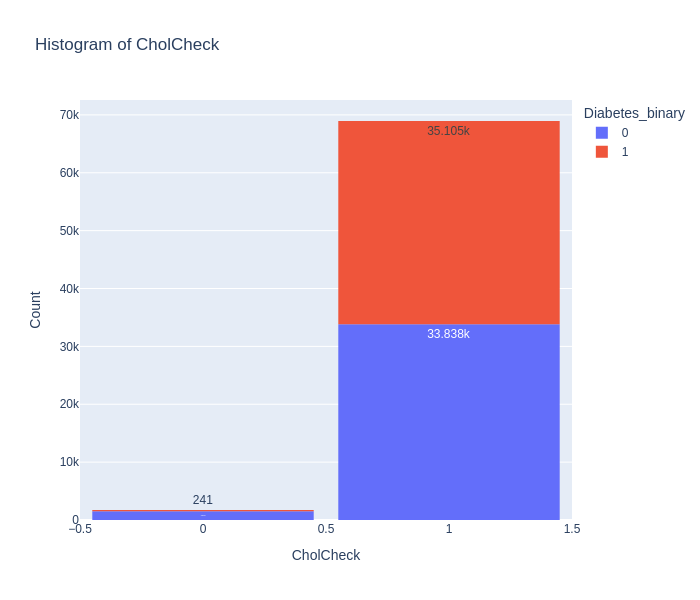

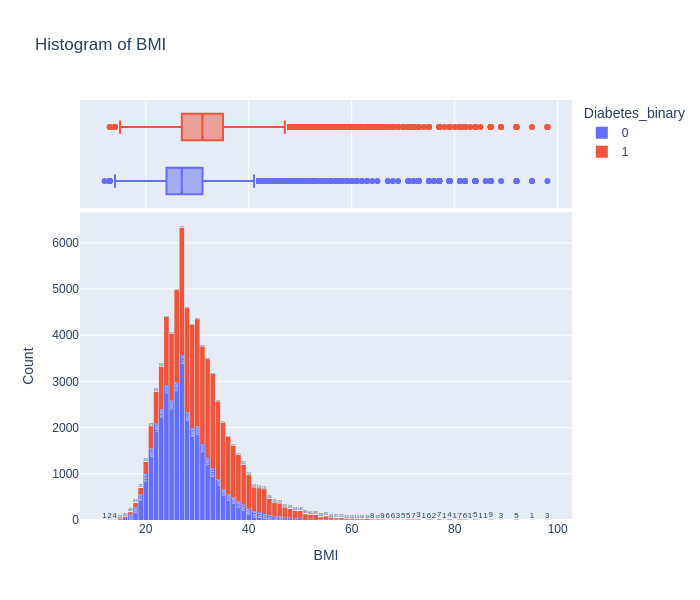

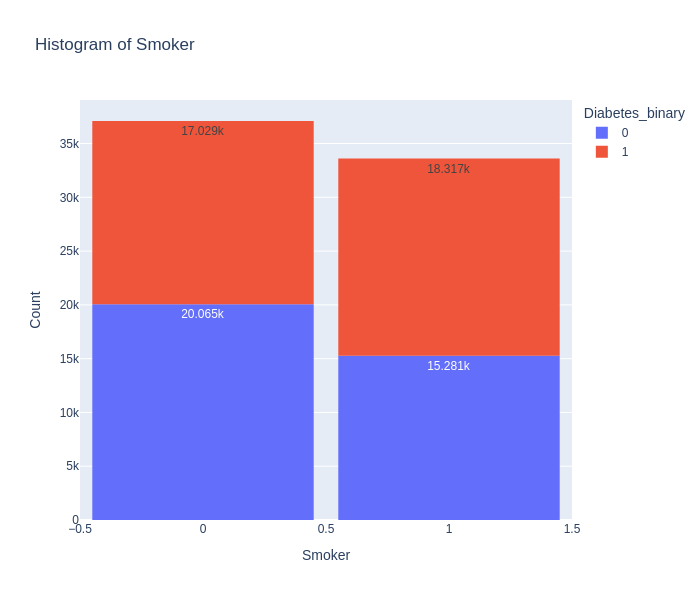

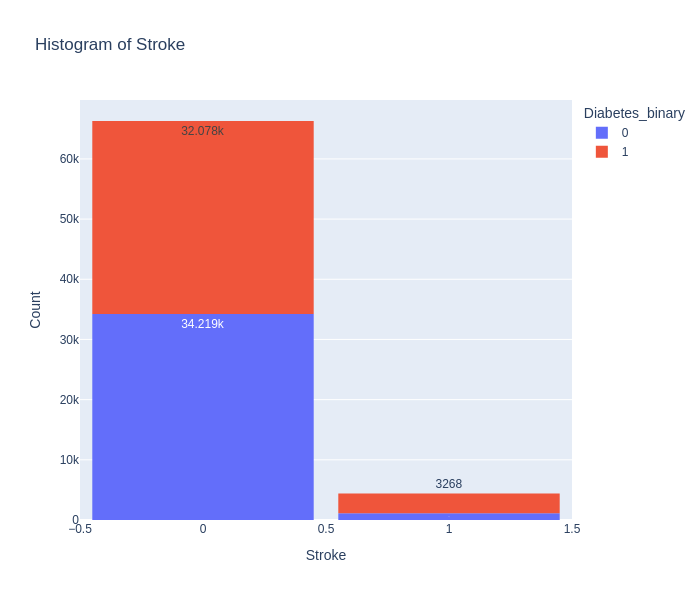

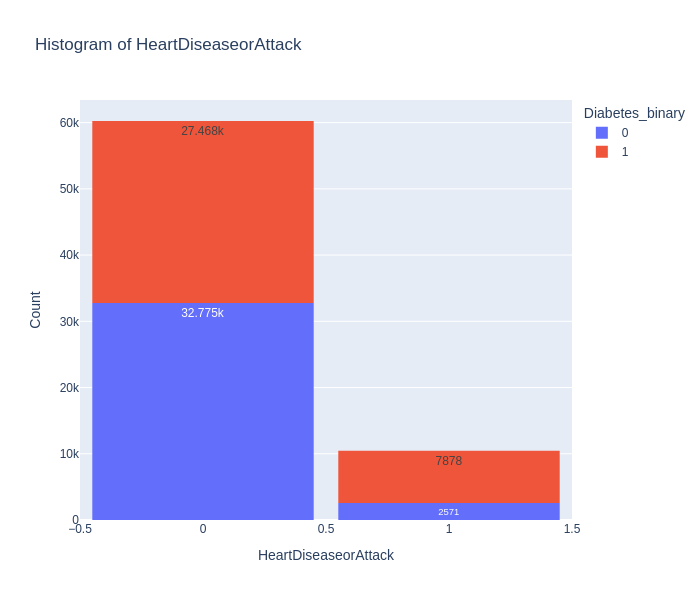

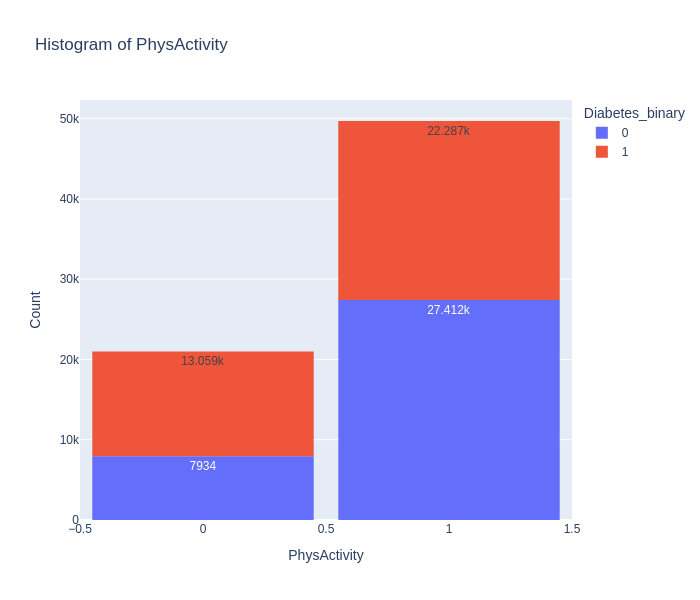

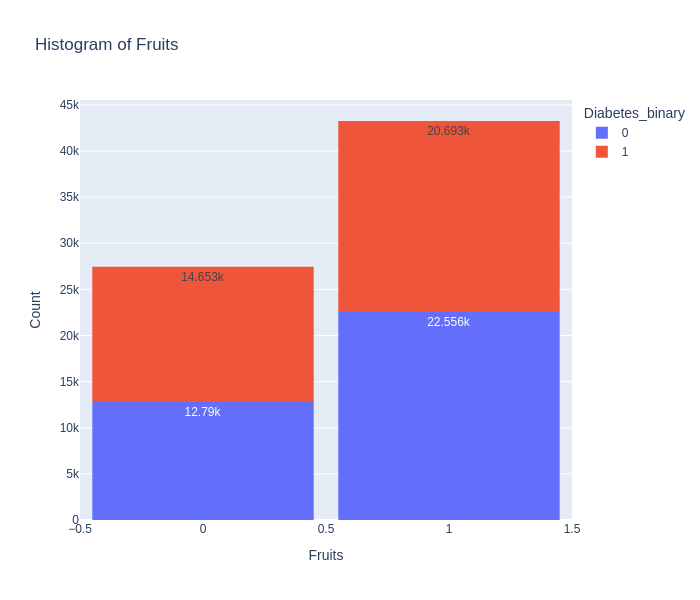

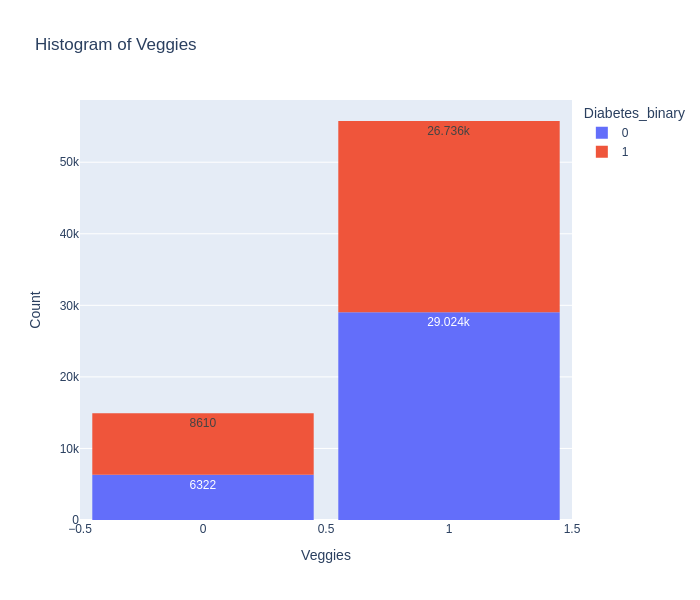

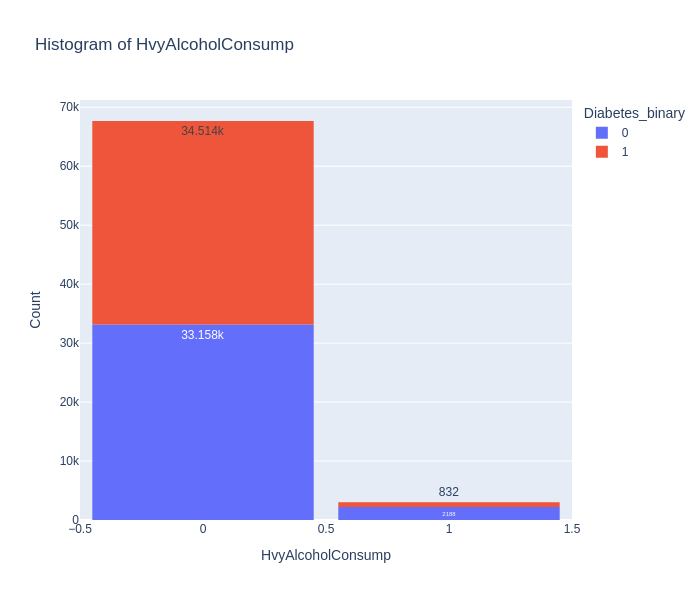

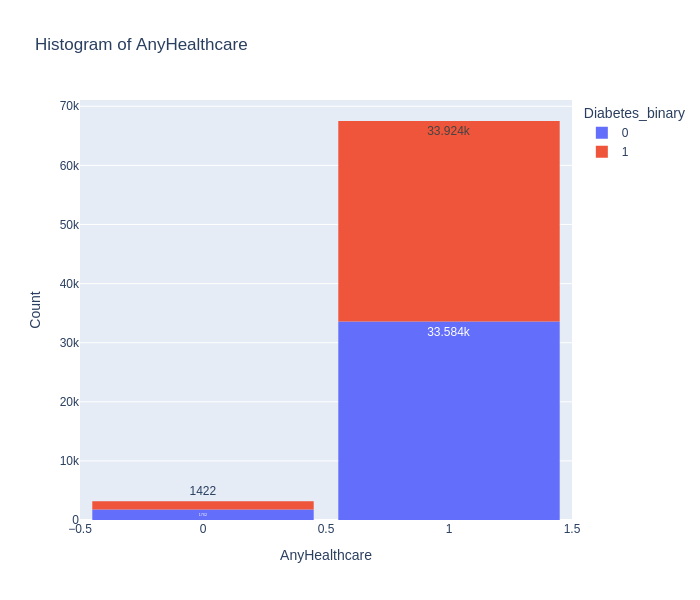

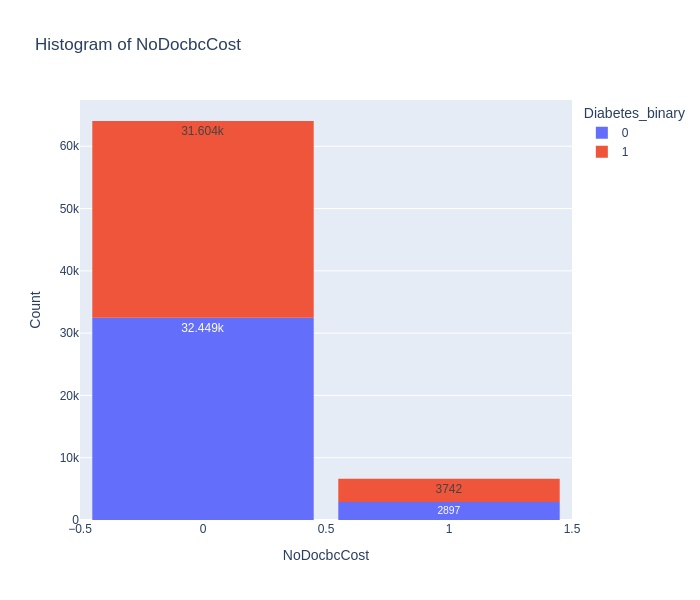

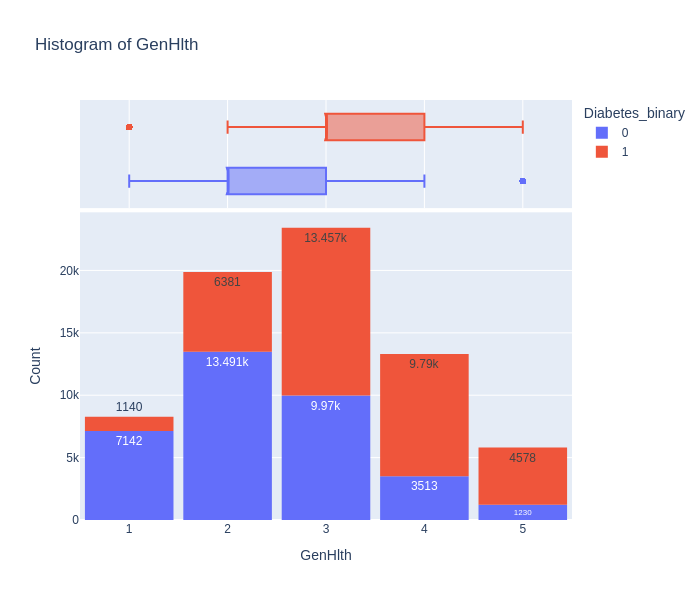

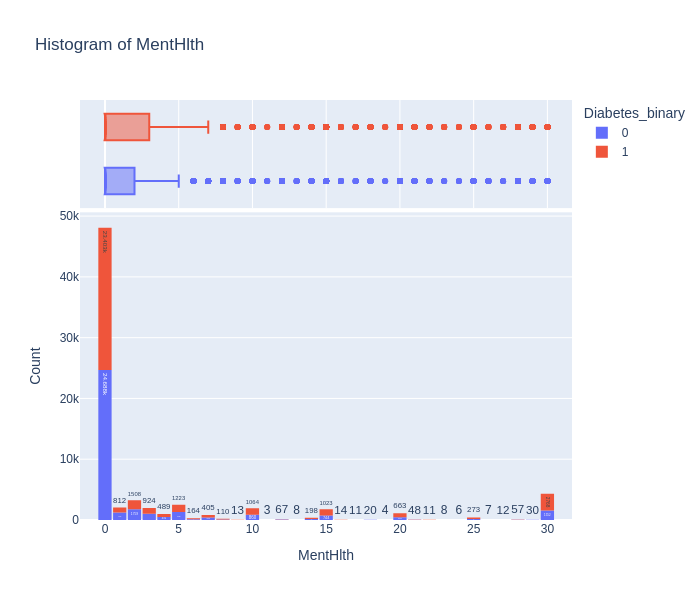

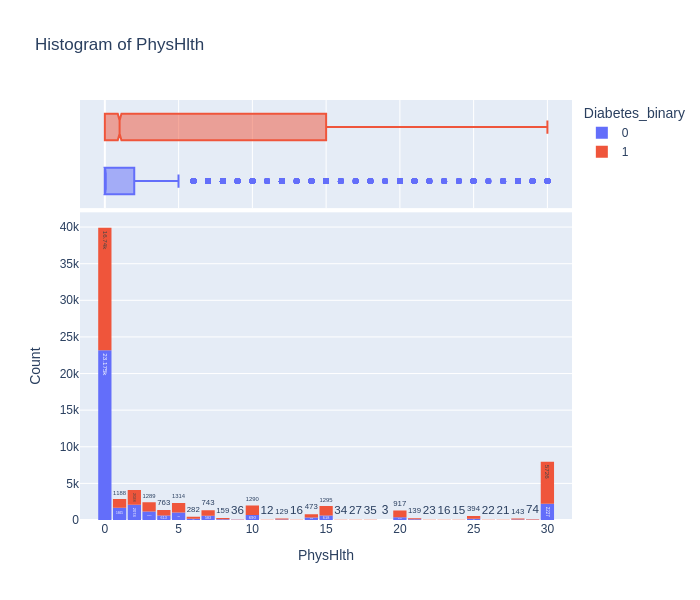

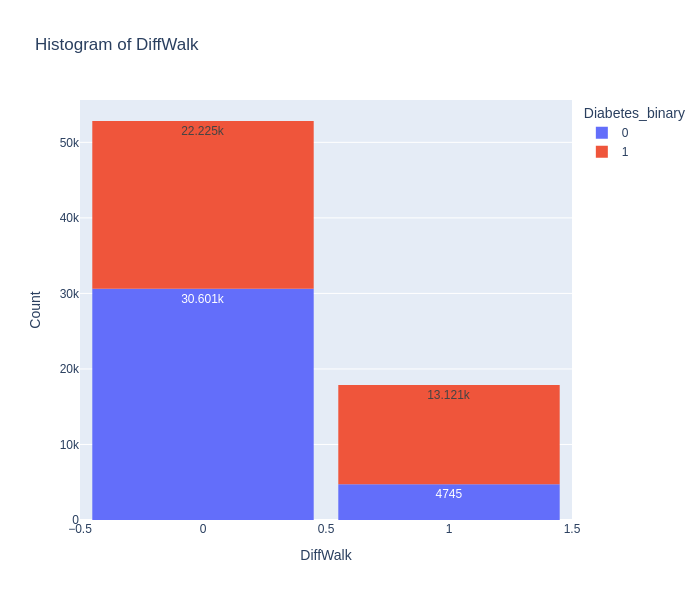

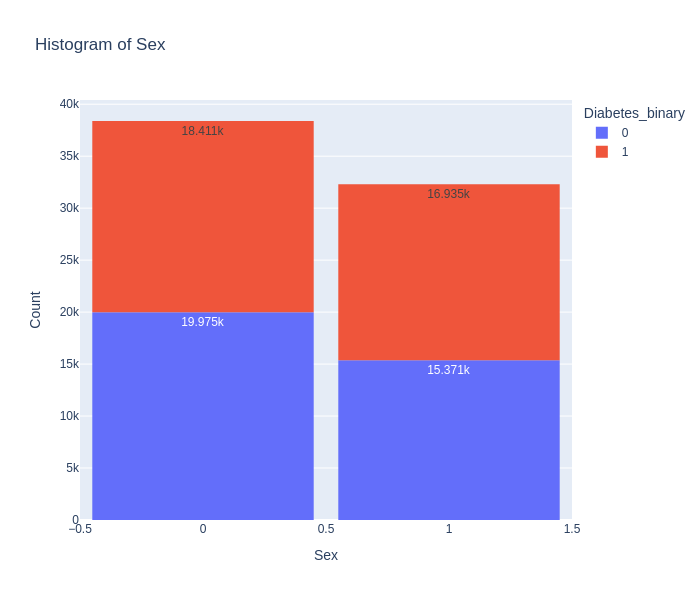

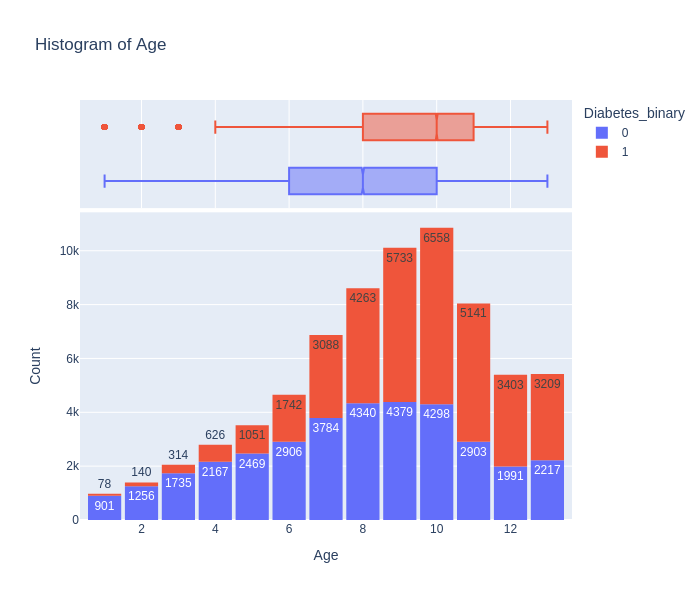

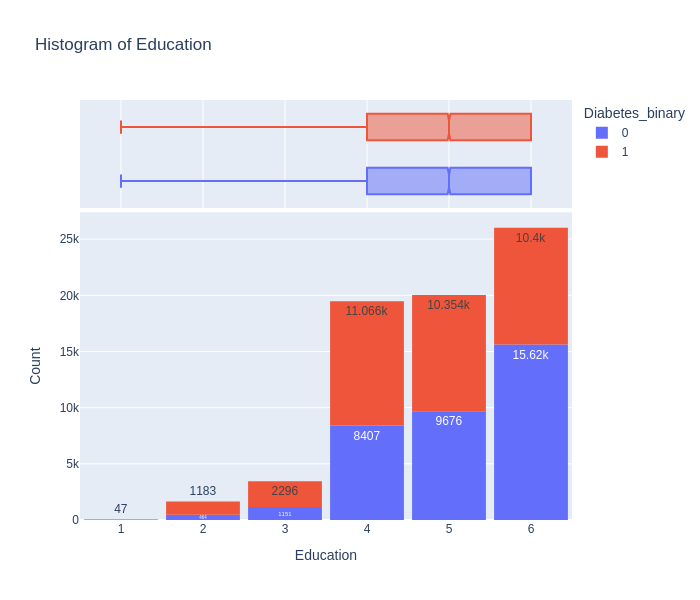

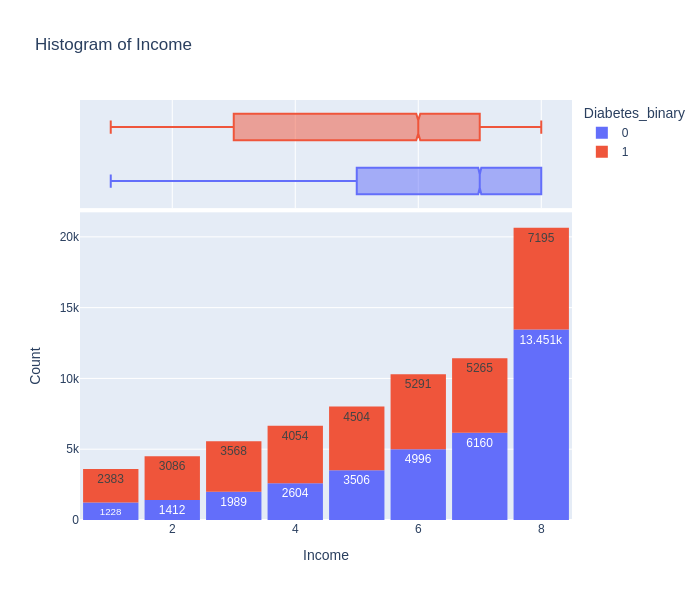

In [3]:
plots_path = './data/plots/'

graphics = utility.Graphics(df=DATA, target='Diabetes_binary', path=plots_path)
graphics.display_histograms()

Gracias a lo cual podemos notar varias cosas:

- Nuestro dataset se encuentra balanceado respecto al _target_ (algo que mencionamos en la descripción inicial del dataset), teniendo 35.346k muestras de cada tipo.
- A mayor presión arterial (`HighBP`), existe mayor posibilidad de tener diabetes. Esto lo podemos ver por el crecimiento de gente que padece diabetes (8k a 26.6k) y el decrecimiento en la que no (22k vs. 13k) respecto a no padecer vs. padecer presión arterial alta.
- Algo similar pasa con el colesterol alto (`HighChol`) con:
  - Con diabetes: 11.6k vs. 23.6k
  - Sin diabetes: 21.8k vs. 13.4k
- La variable de `CholCheck` que pregunta acerca de aquellas personas que se hayan chequeado el colesterol en el último tiempo en el médico tiene un desbalanceamiento enorme dado que son 1.7k los que no y 69k los que sí.
  - Notar que, al no ser muy representativo para nosotros y no estar equilibrada, es una variable que no nos suma en consideración para los modelos
- Respecto al índice de masa corporal (`BMI`), podemos notar la fuerte y gran tendencia de presencia de diabetes dentro de los grupos/universos de personas con un índice bastante alto de masa corporal.
- En cuanto al hecho de fumar (`Smoker`), nos encontramos con una distribución dentro de todo equitativa/uniforme, por lo que no es una _feature_ que nos marque una tendencia o que pueda dividirnos fuertemente el dataset en aquellos que tienen diabetes y aquellos que no. Sin embargo, puede ayudarnos a dividir dentro de subconjuntos ya partidos con anterioridad.
- Con `Stroke` pasa algo similar que con `CholCheck` dado que la cantidad de personas que tuvieron un derrame cerebral no es representativa para poder establecer un patrón o una "regla" respecto al padecimiento de la diabetes y su relación con el derrame cerebral.
- Sucede lo mismo de `Stroke` con `HeartDiseaseorAttack` (aunque llegan a ser 10k las personas que lo sufrieron y, de esos, ~8k tienen diabetes), y con `HvyAlcoholConsump`, `AnyHealthCare`, `NoDocbcCost` (no tienen una muestra equilibrada y representativa).
- Respecto a la realización de actividad física (`PhysActivity`), podemos notar que el 62% de personas que no hacen actividad física (sin considerar el trabajo) padecen diabetes. Esto es un número bastante relevante porque indica una tendencia,
- Con la alimentación (`Fruits` y `Veggies`), lo que podemos obtener son distribuciones equitativas respecto a la presencia de diabetes en cada una de las posibilidades de consumo. Luego, no nos son representativas en primera línea para la creación de los modelos.
- Si vemos las escalas de salud, tenemos que en el caso de la escala _general_ (`GenHlth`), obviamente mientras más pobre sea la salud, entonces mayor proporción de personas van a sufrir diabetes. Y, respecto a la salud _mental_ y _física_ (`MentHlth` y `PhysHlth`), si bien el _grueso_ y la parte más importante y de mayor cantidad de datos se encuentra en el 0 (aquellos que no las sufren), podemos notar que las personas que tienen o padecen de mala salud mental y/o física tienden a tener mayor probabilidad a tener diabetes.
  - Luego, ambas _features_ vamos a considerar importantes para la predicción, tanto por los resultados vistos, como por el propio sentido común según la naturaleza de la consulta.
- Ahora, si nos concentramos en la dificultad a la hora de caminar (`DiffWalk`), como esto se relaciona de forma directa con el estado de la salud física, podemos ver que es muy importante y con mayor porcentaje de diabetes dentro de aquellos a los que les cuesta caminar. Por ello mismo, al estar fuertemente relacionados con las _features_ anteriores, consideraremos que se incluyen indirectamente dentro de estas.
- Los sexos (`Sex`) se encuentran distribuidos, dentro de todo, de forma equitativa, te una presencia mayoritaria de mujeres en el dataset.
- Nivel de educación e ingresos (`Education` e `Income`) son, ambos, features que no tienen ninguna implicancia directa en el padecimiento de la diabetes y que tampoco reflejan una fuerte tendencia más que la que nos afirma que mientras mayor nivel de ambos, mayor cantidad de diabéticos hay. Sin embargo, esto sucede dado que la educación está fuertemente ligada con la edad (no es para nada normal/habitual que un chico de 12 años haya terminado la universidad, por ejemplo). Luego, esto significa que los resultados que obtenemos son principalmente producto de la influencia de la edad en la diabetes.
- Y, por último, llegamos a la edad (`Age`), donde podemos notar lo que mencionamos anteriormente: mientras mayor sea la edad que tengan los encuestados, entonces mayor posibilidad hay de que tengan y padezcan diabetes.

Teniendo todo esto en cuenta, podemos notar claramente que las _features_ que más nos llamaron la atención aquí fueron:

- `HighBP`
- `HighChol`
- `BMI`
- `HeartDiseaseorAttack`
- `PhysActivity`
- `GenHlth`
- `MentHlth`
- `PhysHlth`
- `DiffWalk`
- `Age`


### 4.2. Análisis de correlación


Vamos a analizar la correlación lineal entre las variables, para ver si hay alguna relación entre ellas que nos permita simplificar nuestro modelo o descartar algunas de las features.


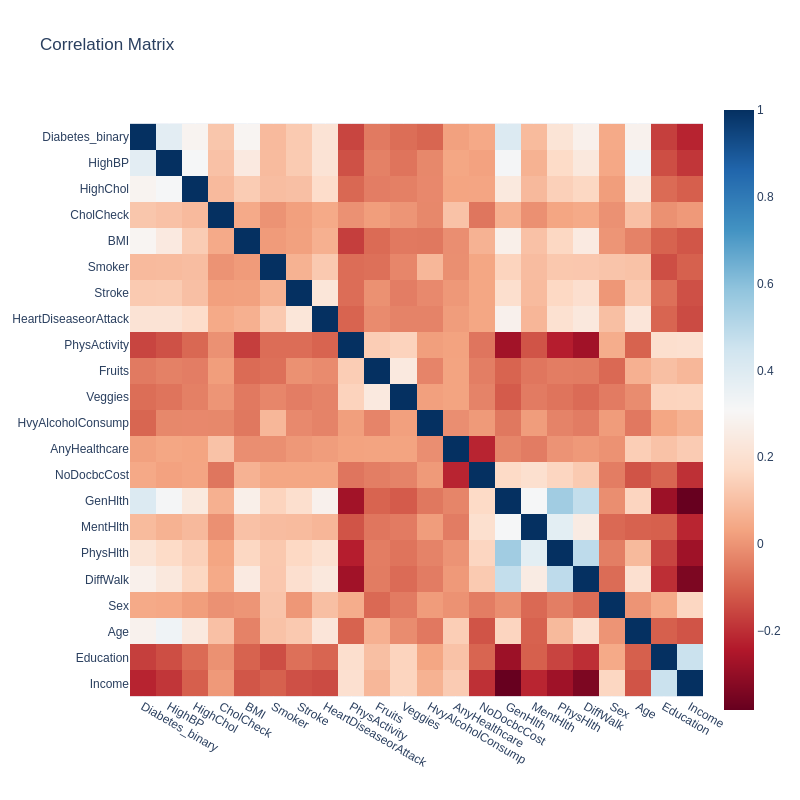

In [4]:
graphics.display_correlation_matrix()

Gracias a lo cual podemos notar que no hay una correlación lineal fuerte entre las variables (sea positiva o negativa), por lo que no vamos a descartar ninguna de ellas con este método.

**Sin embargo**, algo importante que surge de este análisis son las medidas de importancia de las features respecto a la correlación que tienen con la variable objetivo. Por este motivo, podemos notar que aquellas que están más relacionadas _linealmente_ con la presencia de diabetes son:

- `HighBP`: 0.38
- `HighChol`: 0.29
- `BMI`: 0.29
- `Age`: 0.28
- `DiffWalk`: 0.27

Estas tienen una correlación media baja, llegando en el caso de `HighBP` a ser moderada, con la variable de presencia de diabetes. Además, esto nos muestra que son posibles variables a tener en cuenta en nuestros modelos de predicción porque son las que más se relacionan de forma lineal con el objetivo planteado.


### 4.3. Features elegidas


En base a las observaciones realizadas en los anteriores puntos, y teniendo en cuenta que el objetivo del proyecto no es hacer un _EDA_ (i.e., un análisis exploratorio de datos), entonces obviaremos todo el desarrollo y análisis de pairplots, de reducción de componentes, entre otros. Con ello, nos concentraremos de lleno en el desarrollo de modelos y la predicción de la presencia de diabetes en los ciudadanos de Estados Unidos.

Las columnas/features que consideraremos oportunas conservar serán las destacadas en el 1er punto:

- `HighBP`
- `HighChol`
- `BMI`
- `HeartDiseaseorAttack`
- `PhysActivity`
- `GenHlth`
- `MentHlth`
- `PhysHlth`
- `DiffWalk`
- `Age`


## 5. Preprocesamiento y división de datos


### 5.1. Selección de features


En base a lo comentado en el punto anterior, en la inspección del dataset, haremos el filtrado de columnas que consideraremos a la hora de crear los modelos y realizar la predicción.


In [5]:
# Select the columns to use
selected_columns = ['Diabetes_binary', 'HighBP', 'HighChol', 'BMI', 'HeartDiseaseorAttack',
                    'PhysActivity', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Age']

df = DATA[selected_columns]

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Diabetes_binary       70692 non-null  int64
 1   HighBP                70692 non-null  int64
 2   HighChol              70692 non-null  int64
 3   BMI                   70692 non-null  int64
 4   HeartDiseaseorAttack  70692 non-null  int64
 5   PhysActivity          70692 non-null  int64
 6   GenHlth               70692 non-null  int64
 7   MentHlth              70692 non-null  int64
 8   PhysHlth              70692 non-null  int64
 9   DiffWalk              70692 non-null  int64
 10  Age                   70692 non-null  int64
dtypes: int64(11)
memory usage: 5.9 MB


,Diabetes_binary,HighBP,HighChol,BMI,HeartDiseaseorAttack,PhysActivity,GenHlth,MentHlth,PhysHlth,DiffWalk,Age
0,0,1,0,26,0,1,3,5,30,0,4
1,0,1,1,26,0,0,3,0,0,0,12
2,0,0,0,26,0,1,1,0,10,0,13
3,0,1,1,28,0,1,3,0,3,0,11
4,0,0,0,29,0,1,2,0,0,0,8


Habiendo hecho esto, podemos proceder con la división del dataset en 3 conjuntos (entrenamiento, test y validación), y el escalado de los datos para que puedan ser usados en los modelos de MLP.


### 5.2. Escalado de variables


Con el objetivo de que ninguna _feature_ tenga más peso que otra simplemente por su escala, consideraremos realizar un escalamiento de los datos para que la importancia de una característica sea dada por su influencia en la presencia, o no, de la diabetes en el encuestado.


In [6]:
# Scale the data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df_scaled.info()
df_scaled.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   BMI                   70692 non-null  float64
 4   HeartDiseaseorAttack  70692 non-null  float64
 5   PhysActivity          70692 non-null  float64
 6   GenHlth               70692 non-null  float64
 7   MentHlth              70692 non-null  float64
 8   PhysHlth              70692 non-null  float64
 9   DiffWalk              70692 non-null  float64
 10  Age                   70692 non-null  float64
dtypes: float64(11)
memory usage: 5.9 MB


,Diabetes_binary,HighBP,HighChol,BMI,HeartDiseaseorAttack,PhysActivity,GenHlth,MentHlth,PhysHlth,DiffWalk,Age
0,0.0,1.0,0.0,0.162791,0.0,1.0,0.50,0.166667,1.000000,0.0,0.250000
1,0.0,1.0,1.0,0.162791,0.0,0.0,0.50,0.000000,0.000000,0.0,0.916667
2,0.0,0.0,0.0,0.162791,0.0,1.0,0.00,0.000000,0.333333,0.0,1.000000
3,0.0,1.0,1.0,0.186047,0.0,1.0,0.50,0.000000,0.100000,0.0,0.833333
4,0.0,0.0,0.0,0.197674,0.0,1.0,0.25,0.000000,0.000000,0.0,0.583333


### 5.3. División en conjuntos de entrenamiento, testing y validación


Y, como parte final del preprocesamiento de los datos, nos encargaremos de dividir el dataset en los conjuntos de entrenamiento, testing y validación. Consideraremos 70% para entrenamiento, 20% para testing y 10% para validación (para poder evaluar, realmente, la eficiencia de nuestros modelos).

Así mismo, crearemos los _dataset loaders_ (consideraremos inicialmente un batch default de 64) para que puedan ser utilizados por _torch_:


In [7]:
loaders_path = './data/loaders/'

data = utility.Data(df=df_scaled, target='Diabetes_binary', train_size=0.7, test_size=0.2,
                    validation_size=0.1, batch_size=64, path=loaders_path, random_seed=random_seed)

Con todo ello realizado, tenemos listos nuestros conjuntos de datos para proceder con el desarrollo de los modelos y la predicción de la presencia de diabetes en los encuestados, en base a las características seleccionadas.


## 6. Desarrollo de modelos


Procediendo ahora con el desarrollo de los modelos MLP, dado que nuestro conjunto de datos se encuentra balanceado, entonces consideramos oportuno que nuestra métrica de medición principal del _éxito_ en la predicción sea la _accuracy_. De igual modo, tomaremos en cuenta el _f1-score_ como métrica secundaria en caso de necesitar profundizar más en el estado de las predicciones.

Debemos tener en cuenta que en este trabajo se presentarán únicamente $3$ modelos planteados (contando el baseline), entrenados y evaluados para analizar y comparar los resultados obtenidos. Por ello mismo, se han probado diferentes configuraciones de _hiperparámetros_ y arquitecturas de red, pero se presentarán los más representativos y que mejor se adaptan a los datos con los que estamos trabajando.

Así mismo, comentaremos para cada uno cómo fue el proceso para encontrarlo y por qué lo consideramos el mejor para el caso.


### 6.1. Modelo 1: Baseline (_modelo simple_)


El baseline, ha sido elegido de forma aleatoria y sin ningún tipo de análisis previo. Esto se debe a que, como su nombre lo indica, es el modelo base desde el cual partiremos para poder comparar y evaluar los modelos que se presentarán a continuación.

El modelo propuesto es:

- Input size $10$ y output size $2$, como es de esperar
- 2 capas ocultas, ambas de tamaño $20$
- Función de activación _ReLU_ para las capas ocultas
- Sin dropout

Y cuyos hiperparámetros serán:

- Sets con batch size de $64$
- Función de pérdida _CrossEntropyLoss_
- Optimizador _Adam_ con _learning rate_ de $0.01$
- EarlyStopping con _patience_ de $10$ epochs y _delta_ de $0.001$

Podemos ver, a continuación, cómo se comporta este modelo para nuestros datos:


Evaluating Epoch 1: 100%|██████████| 221/221 [00:00<00:00, 2303.80it/s]


Epoch 1/100
	Train Loss: 0.5328, Train Accuracy: 0.7337, Train F1: 0.7327
	Test Loss: 0.5135, Test Accuracy: 0.7420, Test F1: 0.7408


Evaluating Epoch 11: 100%|██████████| 221/221 [00:00<00:00, 2438.27it/s]


Epoch 11/100
	Train Loss: 0.5144, Train Accuracy: 0.7466, Train F1: 0.7458
	Test Loss: 0.5062, Test Accuracy: 0.7502, Test F1: 0.7496


Evaluating Epoch 21: 100%|██████████| 221/221 [00:00<00:00, 2423.90it/s]


Epoch 21/100
	Train Loss: 0.5137, Train Accuracy: 0.7470, Train F1: 0.7464
	Test Loss: 0.5068, Test Accuracy: 0.7499, Test F1: 0.7485


Evaluating Epoch 31: 100%|██████████| 221/221 [00:00<00:00, 2317.41it/s]


Epoch 31/100
	Train Loss: 0.5129, Train Accuracy: 0.7462, Train F1: 0.7455
	Test Loss: 0.5061, Test Accuracy: 0.7517, Test F1: 0.7516


Evaluating Epoch 41: 100%|██████████| 221/221 [00:00<00:00, 2313.97it/s]


Epoch 41/100
	Train Loss: 0.5122, Train Accuracy: 0.7475, Train F1: 0.7468
	Test Loss: 0.5105, Test Accuracy: 0.7530, Test F1: 0.7530


Evaluating Epoch 51: 100%|██████████| 221/221 [00:00<00:00, 2099.60it/s]


Epoch 51/100
	Train Loss: 0.5115, Train Accuracy: 0.7477, Train F1: 0.7470
	Test Loss: 0.5110, Test Accuracy: 0.7495, Test F1: 0.7494
Early stopping at epoch 55

Training finished after 55 epochs
	Train Loss: 0.5120, Train Accuracy: 0.7465, Train F1: 0.7457
	Test Loss: 0.5074, Test Accuracy: 0.7524, Test F1: 0.7521
================================================== PERFORMANCE ==================================================
Best Performance at Epoch 45.0
	Train Loss: 0.5122, Train Accuracy: 0.7466, Train F1: 0.7457
	Test Loss: 0.5047, Test Accuracy: 0.7522, Test F1: 0.7511


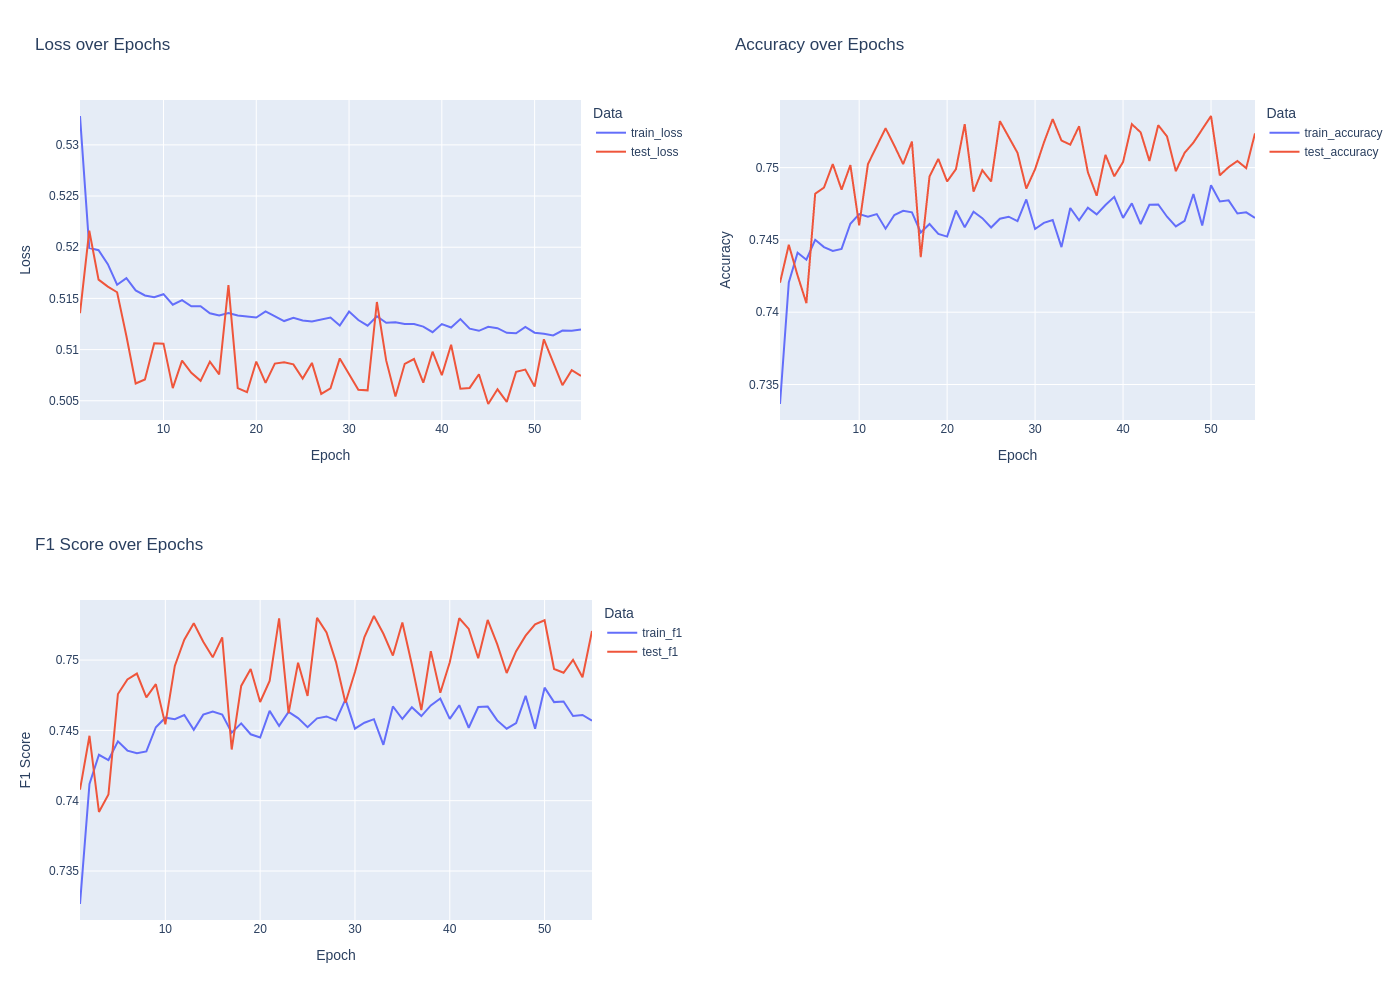

In [8]:
INPUT_SIZE = 10
OUTPUT_SIZE = 2

FOLDER_MODELS_PATH = './data/models/'

base_model_params = {
    'input_size': INPUT_SIZE,
    'hidden_size': [20, 20],
    'output_size': OUTPUT_SIZE,
    'activation_function': nn.ReLU(),
    'dropout': 0.0,
    'random_seed': random_seed
}
base_model = utility.MLP(**base_model_params)

base_model_hyperparams = {
    'n_epochs': 100,
    'train_loader': data.loaders['train'],
    'test_loader': data.loaders['test'],
    'loss_function': nn.CrossEntropyLoss(),
    'optimizer': torch.optim.Adam(base_model.parameters(), lr=0.01),
    'device': device,
    'early_stop_params': {'patience': 10, 'delta': 0.0001}
}

try:
    base_model.load(FOLDER_MODELS_PATH, 'baseline')
except:
    base_model.fit(**base_model_hyperparams)
    base_model.save(FOLDER_MODELS_PATH, 'baseline')

base_model.show_performance()

Gracias a ello, podemos notar que la predicción que logramos obtener es bastante buena, llegando a un 74.66% de acierto en entrenamiento y un 75.22% en validación.

Sin embargo, algo que tenemos que notar es que si bien las curvas de _loss_, _accuracy_ y _f1_ son bastante estables (tengamos en cuenta que la escala de los gráficos involucra rangos menores a 0.05) con una tendencia marcada a mejorar, existen muchos picos y valles que nos indican que el modelo aún puede mejorar y encontrar una mejor convergencia.


### 6.2. Modelo 2: Mejora al baseline


La idea de este modelo no es implementar una arquitectura de red distinta a la del baseline, sino que buscar los mejores parámetros e hiperparámetros para que el modelo pueda converger de mejor manera y, por ende, obtener mejores resultados.

Lo primero en lo que decidí concentrarme fue en el análisis de nuestra **FUNCIÓN DE ACTIVACIÓN** dado que, si bien _ReLU_ es una de las más utilizadas y recomendadas, no es la única y puede que no sea la mejor para nuestro caso. Por ello mismo, decidí probar con las otras dos más usadas (_Sigmoid_ y _Tanh_), y con otras tales como _RReLU_ y _LogSigmoid_ (en realidad probé con muchas más, pero estas fueron las que mejor resultado tuvieron).

Para cada una, pude ver que:

<div align='center'>

| Función de activación | Epoch | Accuracy en entrenamiento | Accuracy en validación |
| --------------------- | ----- | ------------------------- | ---------------------- |
| ReLU                  | 45    | 74.66%                    | 75.22%                 |
| Tanh                  | 13    | 74.34%                    | 75.36%                 |
| Sigmoid               | 27    | 74.70%                    | 75.21%                 |
| RReLU                 | 23    | 74.57%                    | 75.14%                 |
| LogSigmoid            | 27    | 74.66%                    | 75.15%                 |

</div>

Siendo `Tanh` la que mejor resultado obtuvo en validación, pero con unas muy feas e inestables curvas para las métricas de _loss_ y _accuracy_, y sin muestras de mejora a largo plazo, i.e., más epochs (pude notarlo ampliando la paciencia de _EarlyStopping_).

La otra función de activación que me llamó la atención fue `Sigmoid`, dado que es la que obtuvo el mejor resultado en entrenamiento y, además, estuvo muy cerca de `ReLU` en validación. Al tener una mejor curva de _loss_ y _accuracy_, y por lo anterior, decidí quedarme con esta función de activación para el modelo.

Una vez definida la función de activación, debido a que es más estable que `Relu` pero aún tiene picos y valles presentes, activé los **DROPOUTS** en la arquitectura de la red para eliminar aquellos nodos que no nos estén ayudando a mejorar la predicción. A medida que fui probando diferentes valores de probabilidad de dropout, pude notar que mientras mayor sea el resultado, mejor es la convergencia y la estabilidad de las curvas. Sin embargo, este factor también influye en la pérdida de accuracy mientras menos nodos se mantengan activos.

Claramente, al ser una característica de los modelos para evitar overfitting, la accuracy de entrenamiento se ve reducida, pero la validación mejora. Los valores a destacar son:

<div align='center'>

| Dropout | Epoch | Accuracy en entrenamiento | Accuracy en validación |
| ------- | ----- | ------------------------- | ---------------------- |
| 0.0     | 27    | 74.70%                    | 75.21%                 |
| 0.1     | 22    | 74.61%                    | 75.19%                 |
| 0.2     | 22    | 74.41%                    | 75.16%                 |
| 0.3     | 22    | 74.42%                    | 75.31%                 |

</div>

Por lo visto en la anterior tabla, decidí quedarme con un valor de `0.3` para el dropout, dado que es el que mejor resultado obtuvo en validación y, además, es el que mejor curva de _loss_ y _accuracy_ tiene.

Con todo ello, ya analizamos las dos características más importantes de la red, por lo que pasamos ahora a los **HIPERPARÁMETROS**, haciendo foco en el optimizador y el _EarlyStopping_. No analizamos la función de pérdida dado que, como es de esperar, `CrossEntropyLoss` es la mejor para nuestro caso porque es un problema de clasificación y es la que mejor se adapta a nuestra red.

Respecto al **OPTIMIZADOR**, lo primero que hice fue encontrar el mejor _learning rate_ para Adam, el cual fue de $0.015$, obteniendo una accuracy de 74.45% en entrenamiento y 75.38% en validación, por lo que mejora en ambos casos el mejor resultado obtenido hasta el momento.

Los otros optimizadores que probé fueron _SGD_ y _RMSprop_, con mejores learning rates de $0.5$ y $0.01$ respectivamente. Notar que el learning rate de _SGD_ es mucho mayor (es muy grande) porque es un optimizador que necesita de un learning rate más alto para poder converger en un tiempo razonable (pocas epochs). Los resultados que obtuvimos fueron:

<div align='center'>

| Optimizador | Learning rate | Epoch | Accuracy en entrenamiento | Accuracy en validación |
| ----------- | ------------- | ----- | ------------------------- | ---------------------- |
| Adam        | 0.015         | 22    | 74.45%                    | 75.38%                 |
| SGD         | 0.5           | 95    | 74.03%                    | 74.54%                 |
| RMSprop     | 0.01          | 40    | 74.45%                    | 75.27%                 |

</div>

Por ello mismo, nos quedamos con _Adam_ y su _learning rate_ de $0.015$.

Ahora, por último, para el **EARLYSTOPPING**, analizando el gráfico de loss y de accuracy del modelo con Adam(0.015), pude notar que para muy pronto (en la epoch 22) y no tiene suficiente tiempo para aprender y mejorar en totalidad. Por ello mismo, decidí sacar el _EarlyStopping_ y dejar que el modelo se entrene por más tiempo, llegando a un total de $200$ epochs, para poder analizar cómo es el comportamiento de la red y de las predicciones en un tiempo más largo.

Haciendo esto, pude observar que a medida que el modelo se entrena por más tiempo, la accuracy se estabiliza en 74.5% en entrenamiento y 75.2% en validación, lo cual es un resultado bastante bueno y estable. El mejor resultado (con menor _loss_) en este entrenamiento se obtuvo en la epoch 135 con una accuracy de 74.68% en entrenamiento y 75.21% en validación.

Sin embargo, si analizamos directamente el mayor valor de accuracy en validación obtenido, podemos observar que se da en la epoch 26 con un valor de 74.41% en entrenamiento y 75.41% en validación, pero con una loss de 0.5056, lo cual es mayor a la obtenida en la epoch 22: 0.5046. Por este motivo, decidimos quedarnos con el modelo de la epoch 26 (i.e., sacamos el _EarlyStopping_ y dejamos que el modelo se entrene 26 epochs):


Evaluating Epoch 1: 100%|██████████| 221/221 [00:00<00:00, 2063.25it/s]


Epoch 1/26
	Train Loss: 0.5653, Train Accuracy: 0.7083, Train F1: 0.7076
	Test Loss: 0.5213, Test Accuracy: 0.7374, Test F1: 0.7356


Evaluating Epoch 11: 100%|██████████| 221/221 [00:00<00:00, 1939.43it/s]


Epoch 11/26
	Train Loss: 0.5239, Train Accuracy: 0.7431, Train F1: 0.7428
	Test Loss: 0.5075, Test Accuracy: 0.7507, Test F1: 0.7507


Evaluating Epoch 21: 100%|██████████| 221/221 [00:00<00:00, 2425.34it/s]


Epoch 21/26
	Train Loss: 0.5230, Train Accuracy: 0.7439, Train F1: 0.7437
	Test Loss: 0.5066, Test Accuracy: 0.7505, Test F1: 0.7495

Training finished after 26 epochs
	Train Loss: 0.5221, Train Accuracy: 0.7441, Train F1: 0.7438
	Test Loss: 0.5056, Test Accuracy: 0.7541, Test F1: 0.7541
================================================== PERFORMANCE ==================================================
Best Performance at Epoch 22.0
	Train Loss: 0.5217, Train Accuracy: 0.7445, Train F1: 0.7442
	Test Loss: 0.5045, Test Accuracy: 0.7538, Test F1: 0.7537


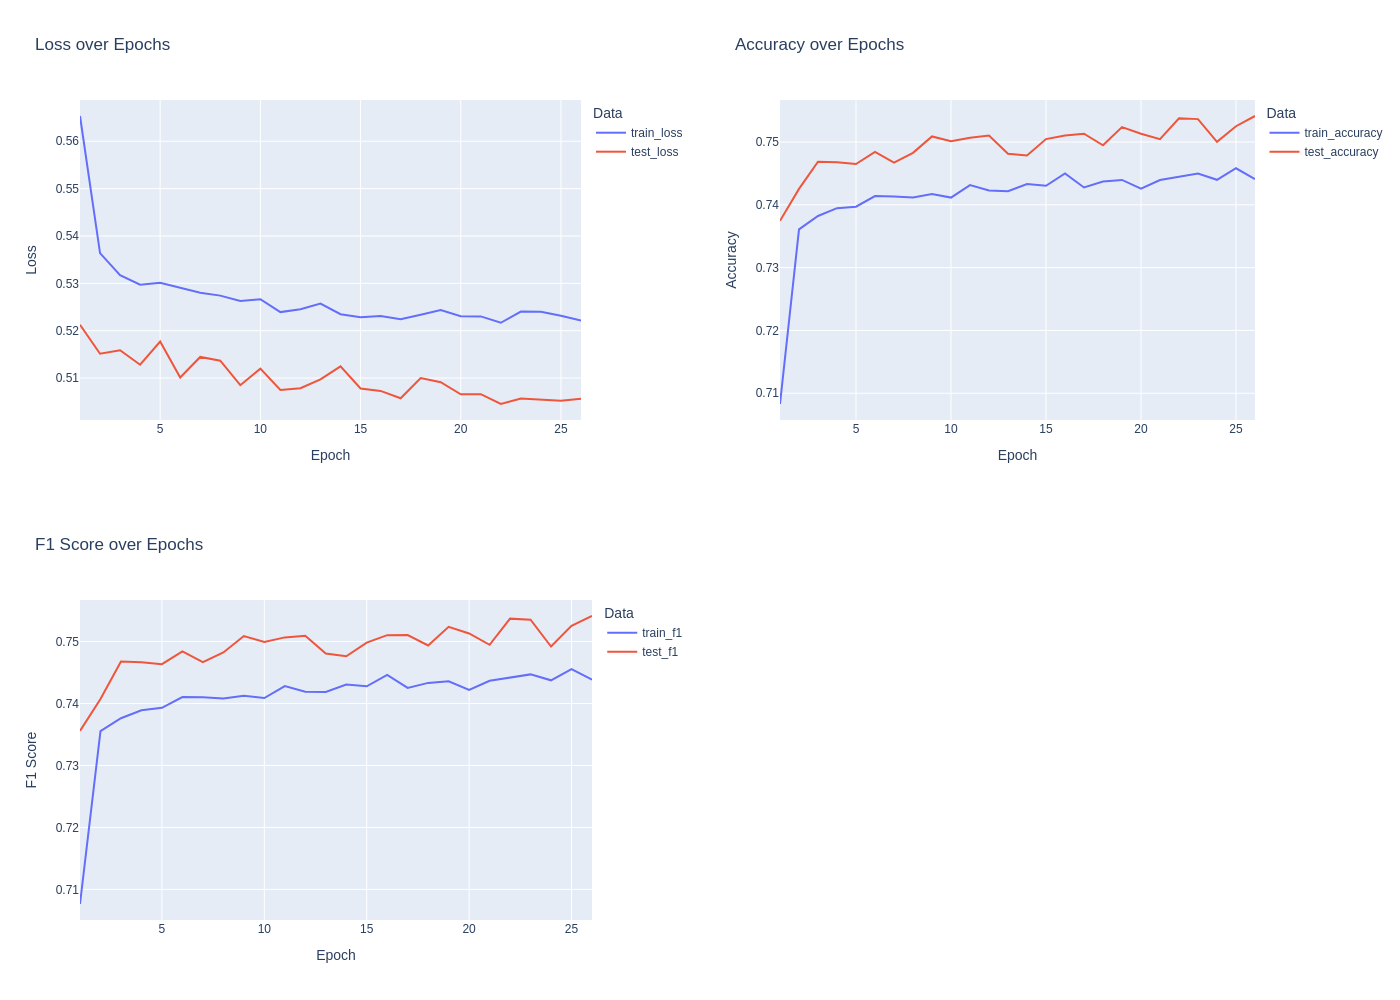

In [9]:
model2_params = {
    'input_size': INPUT_SIZE,
    'hidden_size': [20, 20],
    'output_size': OUTPUT_SIZE,
    'activation_function': nn.Sigmoid(),
    'dropout': 0.3,
    'random_seed': random_seed
}
model2 = utility.MLP(**model2_params)

model2_hyperparams = {
    'n_epochs': 26,
    'train_loader': data.loaders['train'],
    'test_loader': data.loaders['test'],
    'loss_function': nn.CrossEntropyLoss(),
    'optimizer': torch.optim.Adam(model2.parameters(), lr=0.015),
    'device': device,
    'early_stop_params': None
}

try:
    model2.load(FOLDER_MODELS_PATH, 'model2')
except:
    model2.fit(**model2_hyperparams)
    model2.save(FOLDER_MODELS_PATH, 'model2')

model2.show_performance()

Con ello, podemos notar que la performance de nuestro modelo (epoch 26) está dada por:


In [10]:
model2_best_performance = pd.DataFrame(model2.performance.iloc[-1]).T
model2_best_performance = model2_best_performance.set_index('epoch')

display(model2_best_performance)

,train_loss,train_accuracy,train_f1,test_loss,test_accuracy,test_f1
epoch,,,,,,
26.0,0.522146,0.744099,0.74384,0.505614,0.754138,0.754109


Y también podemos observar que las curvas que obtuvimos de _loss_ y _accuracy_ son mucho más estables respecto al _baseline_, lo cual es un indicador de que el modelo está aprendiendo de mejor manera y que, además, está convergiendo de mejor forma.


### 6.3. Modelo 3: Red más profunda


Por último, el tercer modelo a considerar será una red más profunda que las anteriores, con el objetivo de analizar si, al tener más capas y más nodos, podemos obtener una mejor predicción y un mejor resultado en la accuracy.

La idea va a ser totalmente análoga a la realizada con el segundo modelo, pero modificando de primeras la **ARQUITECTURA DE LA RED**. En este caso, se propone una red con $4$ capas ocultas de tamaño $20$, $30$, $30$ y $20$ respectivamente, y con todas las demás características iguales al baseline (i.e., sin dropout, con ReLU como función de activación, con Adam(0.01) como optimizador y con EarlyStopping).

Haciendo esto, podemos ver que el entrenamiento se detiene luego de 21 epochs y se conserva el resultado obtenido en la 11va: 74.40% para entrenamiento y 75.09% para validación. Además, si observamos las curvas de progreso de nuestras métricas a través del tiempo, vamos a poder observar que son muy "feas" e inestables.

Ahora, si analizamos el comportamiento de la red con diferentes **FUNCIONES DE ACTIVACIÓN**, podemos ver que tanto con ReLU como con Tanh, el modelo es sumamente inestable y no logra converger de buena manera. Por otro lado, con Sigmoid hemos podido lograr curvas buenas y estables, y con un resultado mucho mayor al esperado: 74.76% en entrenamiento y 75.32% en validación (en la epoch 29), y con un máximo de accuracy en validación de 75.38% (en la epoch 21).

Los valores, en particular, para cada función de activación son:

<div align='center'>

| Función de activación | Epoch | Accuracy en entrenamiento | Accuracy en validación |
| --------------------- | ----- | ------------------------- | ---------------------- |
| ReLU                  | 21    | 74.40%                    | 75.09%                 |
| Tanh                  | 11    | 74.37%                    | 74.86%                 |
| Sigmoid               | 29    | 74.76%                    | 75.32%                 |

</div>

Por ello mismo, decidimos quedarnos con Sigmoid como función de activación para el modelo, al igual que en el segundo modelo.

Viendo esto, nos queda únicamente analizar el **DROPOUT** para completar los parámetros y la arquitectura de la red. Del mismo modo que con el segundo modelo, podemos observar que a mayor probabilidad de dropout, mejor es la convergencia y la estabilidad de las curvas, en contra de la accuracy del modelo. En este caso, podemos ver los siguientes valores obtenidos para algunas probabilidades:

<div align='center'>

| Dropout | Epoch | Accuracy en entrenamiento | Accuracy en validación |
| ------- | ----- | ------------------------- | ---------------------- |
| 0.00    | 29    | 74.76%                    | 75.32%                 |
| 0.05    | 40    | 74.78%                    | 75.21%                 |
| 0.10    | 25    | 74.39%                    | 75.16%                 |
| 0.20    | 30    | 74.18%                    | 75.00%                 |
| 0.30    | 22    | 74.20%                    | 75.11%                 |

</div>

Por ello mismo, entonces, me decanté por un modelo sin _dropout_.

Pasando ahora con los **HIPERPARÁMETROS**, debemos analizar tanto el optimizador como el EarlyStopping. Si nos concentramos en el **OPTIMIZADOR**, lo primero que vamos a querer hacer es encontrar el mejor _learning rate_ para _Adam_. Haciendo esto, pude notar que a medida que se reduce el _learning rate_, el modelo converge de mejor manera y obtiene mejores resultados para entrenamiento pero no para validación. Los resultados obtenidos para diferentes _learning rates_ son:

<div align='center'>

| Optimizador | Learning rate | Epoch | Accuracy en entrenamiento | Accuracy en validación |
| ----------- | ------------- | ----- | ------------------------- | ---------------------- |
| Adam        | 0.001         | 110   | 74.82%                    | 75.23%                 |
| Adam        | 0.005         | 29    | 74.80%                    | 75.24%                 |
| Adam        | 0.01          | 29    | 74.76%                    | 75.32%                 |
| Adam        | 0.02          | 11    | 74.46%                    | 75.24%                 |

</div>

Motivo de ello, el _learning rate_ que mejor resultado obtuvo fue de $0.01$, por lo que decidimos quedarnos con este valor para Adam. Comparándolo con otros optimizadores, como _SGD_ y _RMSprop_, pudimos notar que es ampliamente superior en cuanto a resultados obtenidos.

Por último, para el **EARLYSTOPPING**, al igual que con el segundo modelo, decidí sacarlo y dejar que el modelo se entrene por más tiempo, llegando a un total de $200$ epochs, para poder analizar cómo es el comportamiento de la red y de las predicciones en un tiempo más largo. Haciendo esto, pude observar que se divide en dos partes:

- Epoch 0 a 100: tanto la accuracy de entrenamiento como la de validación aumentan, aunque en mayor proporción lo hace el set de entrenamiento.
- Epoch 100 a 200: la accuracy de entrenamiento sigue aumentando con la misma tendencia, pero la de validación comienza a disminuir considerablemente.

Se cruzan alrededor de la epoch 110 y esto pasa tanto con el F1 como con la loss (solo que al revés, la loss de validación aumenta y la de entrenamiento disminuye). Por ello mismo, debemos analizar la primera parte dado que la segunda no nos será de utilidad para predecir porque el modelo comienza a empeorar.

Por este motivo, si analizamos cuál es la mayor accuracy obtenida, podemos llegar a que en la epoch 91 obtenemos un 74.76% en entrenamiento y un 75.49% en validación, lo cual es un resultado **muy bueno**, e incluso, el mejor que hemos obtenido hasta el momento. Por ello mismo, decidimos quedarnos con este modelo hasta la epoch 91 y sin _EarlyStopping_:


Evaluating Epoch 1: 100%|██████████| 221/221 [00:00<00:00, 2192.41it/s]


Epoch 1/91
	Train Loss: 0.5579, Train Accuracy: 0.7135, Train F1: 0.7125
	Test Loss: 0.5297, Test Accuracy: 0.7381, Test F1: 0.7336


Evaluating Epoch 11: 100%|██████████| 221/221 [00:00<00:00, 1945.46it/s]


Epoch 11/91
	Train Loss: 0.5158, Train Accuracy: 0.7454, Train F1: 0.7448
	Test Loss: 0.5054, Test Accuracy: 0.7502, Test F1: 0.7496


Evaluating Epoch 21: 100%|██████████| 221/221 [00:00<00:00, 2219.21it/s]


Epoch 21/91
	Train Loss: 0.5126, Train Accuracy: 0.7469, Train F1: 0.7463
	Test Loss: 0.5052, Test Accuracy: 0.7538, Test F1: 0.7534


Evaluating Epoch 31: 100%|██████████| 221/221 [00:00<00:00, 2193.23it/s]


Epoch 31/91
	Train Loss: 0.5121, Train Accuracy: 0.7452, Train F1: 0.7447
	Test Loss: 0.5072, Test Accuracy: 0.7512, Test F1: 0.7512


Evaluating Epoch 41: 100%|██████████| 221/221 [00:00<00:00, 2069.93it/s]


Epoch 41/91
	Train Loss: 0.5111, Train Accuracy: 0.7465, Train F1: 0.7460
	Test Loss: 0.5081, Test Accuracy: 0.7508, Test F1: 0.7508


Evaluating Epoch 51: 100%|██████████| 221/221 [00:00<00:00, 2161.77it/s]


Epoch 51/91
	Train Loss: 0.5107, Train Accuracy: 0.7479, Train F1: 0.7473
	Test Loss: 0.5093, Test Accuracy: 0.7493, Test F1: 0.7469


Evaluating Epoch 61: 100%|██████████| 221/221 [00:00<00:00, 2069.02it/s]


Epoch 61/91
	Train Loss: 0.5108, Train Accuracy: 0.7466, Train F1: 0.7461
	Test Loss: 0.5061, Test Accuracy: 0.7534, Test F1: 0.7533


Evaluating Epoch 71: 100%|██████████| 221/221 [00:00<00:00, 2232.82it/s]


Epoch 71/91
	Train Loss: 0.5091, Train Accuracy: 0.7482, Train F1: 0.7476
	Test Loss: 0.5054, Test Accuracy: 0.7520, Test F1: 0.7517


Evaluating Epoch 81: 100%|██████████| 221/221 [00:00<00:00, 2108.42it/s]


Epoch 81/91
	Train Loss: 0.5091, Train Accuracy: 0.7478, Train F1: 0.7473
	Test Loss: 0.5058, Test Accuracy: 0.7531, Test F1: 0.7523


Evaluating Epoch 91: 100%|██████████| 221/221 [00:00<00:00, 2031.68it/s]


Epoch 91/91
	Train Loss: 0.5084, Train Accuracy: 0.7481, Train F1: 0.7476
	Test Loss: 0.5053, Test Accuracy: 0.7549, Test F1: 0.7547

Training finished after 91 epochs
	Train Loss: 0.5084, Train Accuracy: 0.7481, Train F1: 0.7476
	Test Loss: 0.5053, Test Accuracy: 0.7549, Test F1: 0.7547
================================================== PERFORMANCE ==================================================
Best Performance at Epoch 29.0
	Train Loss: 0.5120, Train Accuracy: 0.7476, Train F1: 0.7470
	Test Loss: 0.5035, Test Accuracy: 0.7532, Test F1: 0.7531


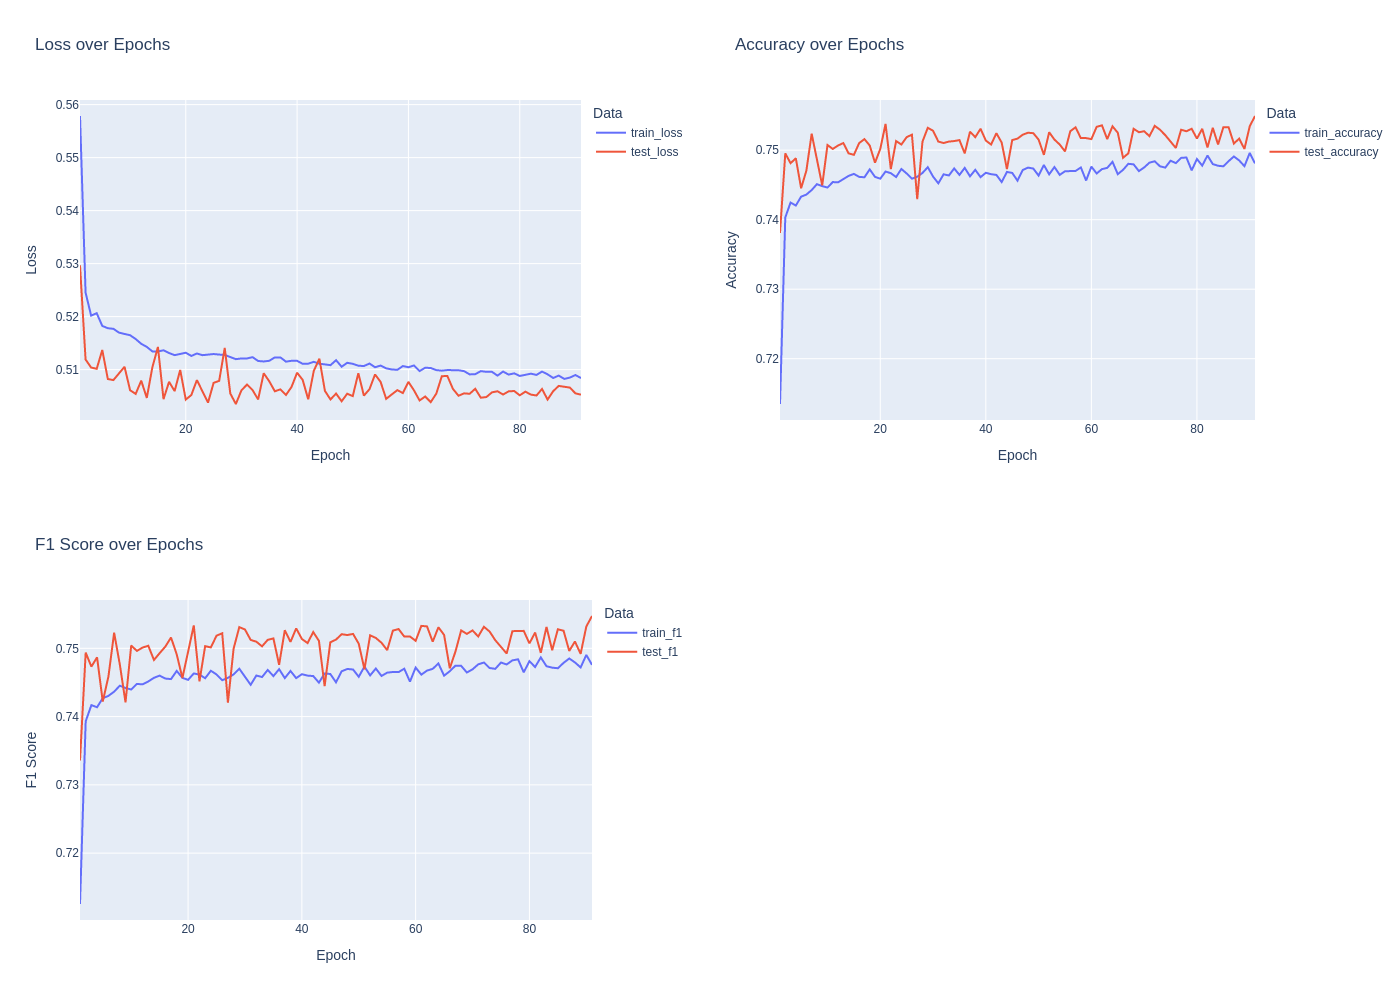

In [11]:
model3_params = {
    'input_size': INPUT_SIZE,
    'hidden_size': [20, 30, 30, 20],
    'output_size': OUTPUT_SIZE,
    'activation_function': nn.Sigmoid(),
    'dropout': 0.0,
    'random_seed': random_seed
}
model3 = utility.MLP(**model3_params)

model3_hyperparams = {
    'n_epochs': 91,
    'train_loader': data.loaders['train'],
    'test_loader': data.loaders['test'],
    'loss_function': nn.CrossEntropyLoss(),
    'optimizer': torch.optim.Adam(model3.parameters(), lr=0.01),
    'device': device
}

try:
    model3.load(FOLDER_MODELS_PATH, 'model3')
except:
    model3.fit(**model3_hyperparams)
    model3.save(FOLDER_MODELS_PATH, 'model3')

model3.show_performance()

Con ello, podemos notar que la performance de nuestro modelo (epoch 91) está dada por:


In [12]:
model3_best_performance = pd.DataFrame(model3.performance.iloc[-1]).T
model3_best_performance = model3_best_performance.set_index('epoch')

display(model3_best_performance)

,train_loss,train_accuracy,train_f1,test_loss,test_accuracy,test_f1
epoch,,,,,,
91.0,0.508396,0.7481,0.747583,0.505264,0.754916,0.754734


Y también podemos observar que las curvas que obtuvimos de _loss_ y _accuracy_ son mucho más estables respecto al _baseline_, lo cual es un indicador de que el modelo está aprendiendo de mejor manera y que, además, está convergiendo de mejor forma. Sin embargo, el segundo modelo sigue siendo el más estable de los tres.


## 7. Comparación de modelos


Habiendo desarrollado los tres modelos, podemos proceder a compararlos y analizar cuál es el mejor para nuestro caso. Para ello, vamos a analizar todas las métricas obtenidas en cada uno de los modelos y, además, vamos a realizar un análisis de los resultados obtenidos en cada uno de ellos.

Para ello, observemos la comparativa de las métricas para cada uno de los modelos:


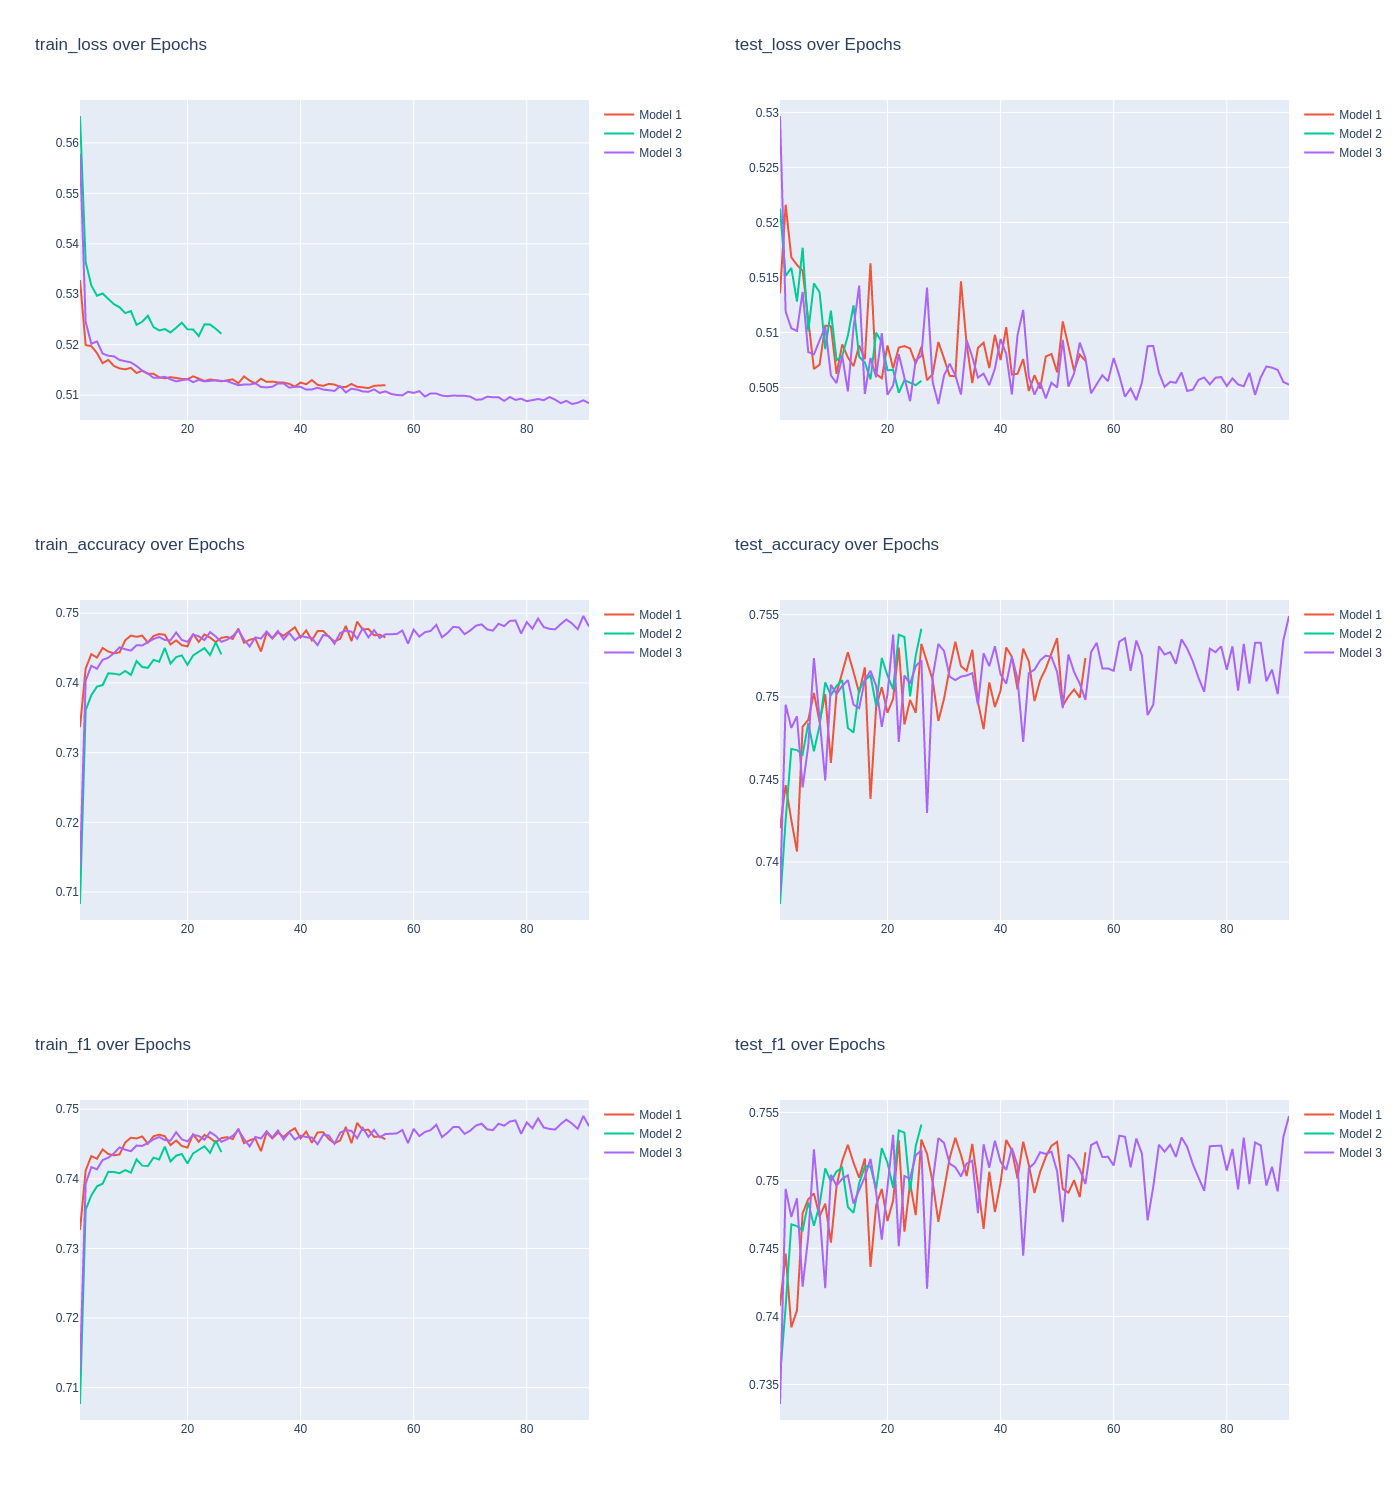

In [13]:
utility.compare_models_performance([base_model.performance, model2.performance, model3.performance])

Con ello, entonces, podemos ver efectivamente que el modelo más estable (sin tantos picos y valles) es el segundo modelo, pero siendo el baseline y el tercer modelo aquellos que tienen una mejor convergencia (tener en cuenta que también son los que más epochs se entrenaron).

Además, podemos ver claramente que el modelo con los mejores valores en los seis gráficos es el tercero:

- Mejor loss en entrenamiento y validación
- Mejor accuracy en entrenamiento y validación
- Mejor f1 en entrenamiento y validación

Por ello, entonces, podemos concluir que el mejor modelo para nuestro caso es el tercero.

Ahora bien, eso es en base a las métricas obtenidas y a los resultados que hemos analizado. Sin embargo, el factor decisivo para elegir un modelo u otro es el análisis de la precisión de las predicciones y de la capacidad de generalización de los modelos. Por ello mismo, vamos a ver la accuracy y el f1-score para cada uno de los modelos en el conjunto de validación:


In [14]:
base_model_validation = base_model.validate(data.loaders['validation'], device)
model2_validation = model2.validate(data.loaders['validation'], device)
model3_validation = model3.validate(data.loaders['validation'], device)

validation = pd.DataFrame({'baseline': base_model_validation,
                           'model2': model2_validation,
                           'model3': model3_validation}, index=['Accuracy', 'F1 score']).T

display(validation)

,Accuracy,F1 score
baseline,0.744272,0.743760
model2,0.747242,0.747087
model3,0.746959,0.746598


Donde podemos observar que los resultados obtenidos en el segundo y tercer modelo son muy similares, pero el segundo es el que mejor resultado obtiene en ambas métricas.


## 8. Conclusión


Como pudimos observar a lo largo de todo el desarrollo del proyecto, el modelo que mejor se adaptó a los datos y que mejor predicción realizó fue el segundo modelo, el cual es un modelo más simple que el tercero y que el baseline, y que requirió de menos tiempo de entrenamiento para poder obtener los resultados que obtuvo.

En base a ello, entonces, podemos concluir que para la predicción de la presencia de diabetes en los encuestados, el mejor modelo es el dado por:

- Input size $10$ y output size $2$
- 2 capas ocultas, ambas de tamaño $20$
- Función de activación _Sigmoid_ para las capas ocultas
- Dropout de $0.3$
- Sets con batch size de $64$
- Función de pérdida _CrossEntropyLoss_
- Optimizador _Adam_ con _learning rate_ de $0.015$
- Sin _EarlyStopping_ y con un total de $26$ epochs
